    time    u         y
0    0.0  0.0  0.000000
1    0.8  0.0  0.000000
2    1.6  0.0  0.000000
3    2.4  0.0  0.000000
4    3.2  0.0  0.000000
5    4.0  1.0  0.000021
6    4.8  1.0  0.005286
7    5.6  1.0  0.075424
8    6.4  1.0  0.342602
9    7.2  1.0  0.850127
10   8.0  1.0  1.473414
11   8.8  1.0  2.042382
12   9.6  1.0  2.461702
13  10.4  1.0  2.724682
14  11.2  1.0  2.870105
15  12.0  1.0  2.942806
16  12.8  1.0  2.976270
17  13.6  1.0  2.990648
18  14.4  1.0  2.996477
19  15.2  1.0  2.998724
20  16.0  0.1  2.999534
21  16.8  0.1  2.995092
22  17.6  0.1  2.932069
23  18.4  0.1  2.691642
24  19.2  0.1  2.234880
25  20.0  0.1  1.673926
26  20.8  0.1  1.161855
27  21.6  0.1  0.784468
28  22.4  0.1  0.547786
29  23.2  0.1  0.416906
30  24.0  0.5  0.351483
31  24.8  0.5  0.323471
32  25.6  0.5  0.338586
33  26.4  0.5  0.440212
34  27.2  0.5  0.641200
35  28.0  0.5  0.889767
36  28.8  0.5  1.117089
37  29.6  0.5  1.284726
38  30.4  0.5  1.389887
39  31.2  0.5  1.448046
40  32.0  0.5  1

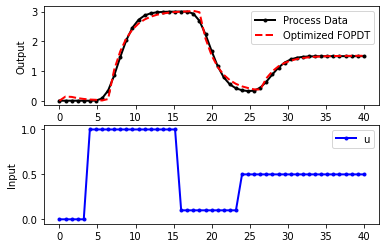

In [2]:
import numpy as np
import pandas as pd
from gekko import GEKKO
import matplotlib.pyplot as plt

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
y = data['y'].values

print(data)

m = GEKKO(remote=False)
m.time = t; time = m.Var(0); m.Equation(time.dt()==1)

K = m.FV(2,lb=0,ub=10);      K.STATUS=1
tau = m.FV(3,lb=1,ub=200);  tau.STATUS=1
theta = m.FV(0,lb=0,ub=30); theta.STATUS=1

# create cubic spline with t versus u
uc = m.Var(u); tc = m.Var(t); m.Equation(tc==time-theta)
m.cspline(tc,uc,t,u,bound_x=False)

ym = m.Param(y); yp = m.Var(y)
m.Equation(tau*yp.dt()+(yp-y[0])==K*(uc-u[0]))

m.Minimize((yp-ym)**2)

m.options.IMODE=5
m.solve(disp = False)

print('Kp: ', K.value[0])
print('taup: ',  tau.value[0])
print('thetap: ', theta.value[0])

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,y,'k.-',lw=2,label='Process Data')
plt.plot(t,yp.value,'r--',lw=2,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend()
plt.subplot(2,1,2)
plt.plot(t,u,'b.-',lw=2,label='u')
plt.legend()
plt.ylabel('Input')
plt.show()